# Is it a House or an Apartment?

#### Can the information regarding properties on sale in a London Borough tell us anything about the properties on sale in its neighbouring Borough? Let's find out!

Here I start with some cleaning and exploratory data analysis of the properties on sale in Greenwich and then use K-Nearest Neighbours for labelling properties into two classes: House or Apartment.

Finally, as a 'model deployment' step, the K-Nearest Neighbours model fitted using the Greenwich dataset is used to classify the properties on sale in Bexley i.e. its neighbour.

### Source of Data:

Data obtained from rightmove using the web scraping code found in the "Web_Scrap_Rightmove.ipynb" project.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
plt.style.use('seaborn')

In [2]:
#Reading the csv file, obtained by web scraping, into pandas DataFrame
properties = pd.read_csv("rightmove_Greenwich.csv")

#Viewing the data
properties.head()

,Price (£),Property Type,Bedrooms,Bathrooms,"Size, sq. ft."
0,"449,995",Apartment,1.0,1.0,551
1,"750,000",Flat,2.0,2.0,"1,276"
2,"300,000",Flat,2.0,1.0,NaN
3,"385,000",NaN,1.0,1.0,NaN
4,"550,000",Apartment,2.0,2.0,NaN


Need to remove the commas from the values in the price column.

In [3]:
#Summarised information 
properties.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Price (£)      1050 non-null   object 
 1   Property Type  1048 non-null   object 
 2   Bedrooms       1039 non-null   float64
 3   Bathrooms      990 non-null    float64
 4   Size, sq. ft.  218 non-null    object 
dtypes: float64(2), object(3)
memory usage: 41.1+ KB


Need to change the type of the price column to float. Since ~80% of the size column is null, we shall just ignore it for now (later can check if adding size makes classification perform better).

## 1) Data Cleaning and Exploration

Let's begin by cleaning the data to make it ready for exploration and classification.

In [4]:
#Removing the commas from the price column by using .apply
properties["Price (£)"] = properties["Price (£)"].apply(lambda x: ''.join(x.split(',')))

properties.head()

,Price (£),Property Type,Bedrooms,Bathrooms,"Size, sq. ft."
0,449995,Apartment,1.0,1.0,551
1,750000,Flat,2.0,2.0,"1,276"
2,300000,Flat,2.0,1.0,NaN
3,385000,NaN,1.0,1.0,NaN
4,550000,Apartment,2.0,2.0,NaN


In [5]:
#Changing the dtype of the price column to float using .astype
properties["Price (£)"] = properties["Price (£)"].astype('float64')

properties.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Price (£)      1050 non-null   float64
 1   Property Type  1048 non-null   object 
 2   Bedrooms       1039 non-null   float64
 3   Bathrooms      990 non-null    float64
 4   Size, sq. ft.  218 non-null    object 
dtypes: float64(3), object(2)
memory usage: 41.1+ KB


Next we will explore the classification target variable, "Property Type", and reformat it to contain just "House" and "Apartment" categories.

In [6]:
#Viewing the different categories present in the Property Type column
properties["Property Type"].unique()

array(['Apartment', 'Flat', nan, 'Terraced', 'End of Terrace',
       'Semi-Detached', 'Maisonette', 'Town House', 'House', 'Bungalow',
       'Detached', 'Ground Flat', 'Penthouse', 'Cottage',
       'Retirement Property', 'Plot', 'Studio', 'Detached Bungalow',
       'Ground Maisonette', 'Link Detached House',
       'House of Multiple Occupation', 'Semi-Detached Bungalow'],
      dtype=object)

In [7]:
#Selecting the apartment like categories to "Apartment" 
apartment_types = ["Flat", "Maisonette", "Ground Flat", "Penthouse", "Studio", "Ground Maisonette" ]

#Iterating over the apartment like categories and replacing each value with "Apartment"
for type in apartment_types:
    properties["Property Type"] = properties["Property Type"].replace(type, "Apartment")

In [8]:
#Selecting the house like categories to "House" 
house_types = ["Terraced", "Semi-Detached", "End of Terrace", "Detached", "House", "Town House", "Retirement Property", "Bungalow", "Cottage", "Detached Bungalow", 
               "Link Detached House", "Semi-Detached Bungalow", "House of Multiple Occupation"  ]

#Iterating over the house like categories and replacing each value with "House"
for type in house_types:
    properties["Property Type"] = properties["Property Type"].replace(type, "House")

In [9]:
properties["Property Type"].unique()

array(['Apartment', nan, 'House', 'Plot'], dtype=object)

There still remains Null values and "Plot" property type to be removed.

In [10]:
#Checking the index of "Plot"
properties[ properties["Property Type"] == "Plot" ]

,Price (£),Property Type,Bedrooms,Bathrooms,"Size, sq. ft."
345,900000.0,Plot,NaN,NaN,NaN


In [11]:
#Dropping index 345 and resetting index values
properties.drop(index = 345, inplace = True)
properties.reset_index(inplace = True, drop = True)

properties["Property Type"].unique()

array(['Apartment', nan, 'House'], dtype=object)

In [12]:
properties.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1049 entries, 0 to 1048
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Price (£)      1049 non-null   float64
 1   Property Type  1047 non-null   object 
 2   Bedrooms       1039 non-null   float64
 3   Bathrooms      990 non-null    float64
 4   Size, sq. ft.  218 non-null    object 
dtypes: float64(3), object(2)
memory usage: 41.1+ KB


Next we drop the missing values from property type, bedrooms and bathrooms since these features will be central for our classification model. It does not make much sense to replace the missing values with the mean or mode as the combination of the property type, bedrooms and bathrooms might not represent the given price. 

In [13]:
#Dropping the null rows
properties.dropna(subset = ["Property Type", "Bedrooms", "Bathrooms"], inplace = True)

properties.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 981 entries, 0 to 1048
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Price (£)      981 non-null    float64
 1   Property Type  981 non-null    object 
 2   Bedrooms       981 non-null    float64
 3   Bathrooms      981 non-null    float64
 4   Size, sq. ft.  207 non-null    object 
dtypes: float64(3), object(2)
memory usage: 46.0+ KB


Let's visualise the data to gain some more insight.

In [14]:
#Seperating out the house and apartment type
houses = properties[ properties["Property Type"] == "House" ].copy()
apartments = properties[ properties["Property Type"] == "Apartment" ].copy()

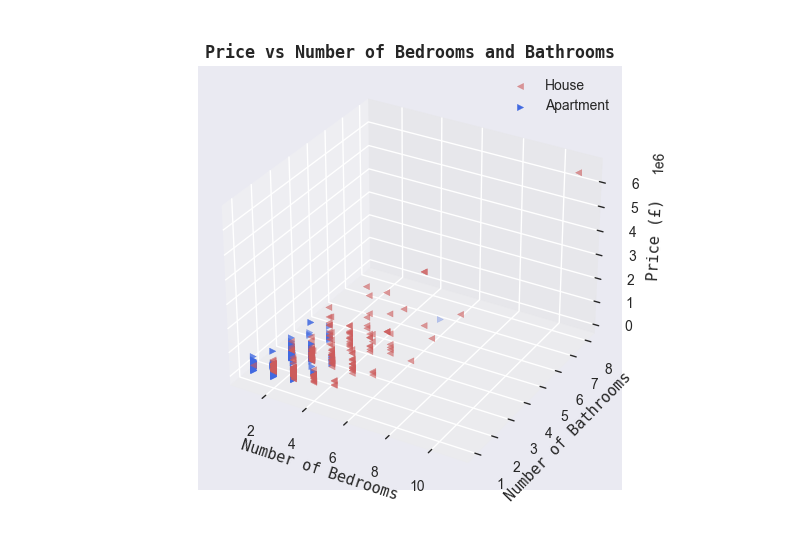

In [15]:
#Interactive plot
%matplotlib widget

#Figure object with 3d axes
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

#Scatter plot of the property prices vs number of bedroom and bathroom
ax.scatter(houses.Bedrooms, houses.Bathrooms, houses["Price (£)"],  c = 'indianred', label = 'House', marker = '<', alpha = 0.6)
ax.scatter(apartments.Bedrooms, apartments.Bathrooms, apartments["Price (£)"], c = 'royalblue', label = 'Apartment', marker = '>')

#Setting the different labels on the plo
ax.set_title( "Price vs Number of Bedrooms and Bathrooms", family = "monospace", fontweight="bold" )
ax.set_xlabel( "Number of Bedrooms ", family = "monospace" )
ax.set_ylabel( "Number of Bathrooms ", family = "monospace" )
ax.set_zlabel( "Price (£)", family = "monospace" )
plt.legend()

We see that the houses tend to be closer to each other, especially for higher number of bedrooms while the opposite looks true for the apartments. Thus, it seems reasonable to expect a good classification model using k-nearest neighbours.  

## 2) Classification: K-Nearest Neighbours

Let's use k-nn to classify different properties into two classes: Apartment or House. We will use the price, number of bedroom and bathroom as the features and f1-score as the evaluation metric.

In [16]:
#Necessary libraries for classification (k-nn)
from sklearn.neighbors import KNeighborsClassifier as KNC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

#Classification metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

In [17]:
#Selecting the features being used for classification
features = ["Price (£)", "Bedrooms", "Bathrooms"]
X = properties[features]

#The target variable: Apartment or House
y = properties["Property Type"]

In [18]:
#Generating the random number for the random_state
#np.random.randint(0,150)

In [19]:
#Train-test split; fixed random state for reproducibility 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 133)

In [20]:
#Creating pipeline object to unify the scaling and fitting process, in a sequential order: k = 5 for now
pipe = Pipeline( [('Scaling', StandardScaler()), ('Classifier', KNC( n_neighbors = 5 ) )] )

In [21]:
#Training the model
pipe.fit(X_train, y_train)

Pipeline(steps=[('Scaling', StandardScaler()),
                ('Classifier', KNeighborsClassifier())])

In [22]:
#Average accuracy
pipe.score(X_test, y_test)

0.8858024691358025

Although the average accuracy is around 88.5%, the dataset is not quite balanced and we need a different evaluation metric; around 37% of the data is House while 63% is Apartment. We shall use the f1-score as the evaluation metric.

In [23]:
#Predicted labels
y_pred = pipe.predict(X_test)

#Confusion matrix that can be used to calculate various evaluation metric such as precision and recall
confusion_matrix(y_pred, y_test)

array([[178,  23],
       [ 14, 109]])

In [24]:
#Classification report that summarises the different metrics for each class
print( classification_report(y_pred, y_test) )

              precision    recall  f1-score   support

   Apartment       0.93      0.89      0.91       201
       House       0.83      0.89      0.85       123

    accuracy                           0.89       324
   macro avg       0.88      0.89      0.88       324
weighted avg       0.89      0.89      0.89       324



More precisely, we look at the harmonic average of the f1-scores; this will highlight any extreme scores and we get a fairer assessment.

In [25]:
#Function to calculate the harmonic mean given a list of numbers: parameter numbers is a list
def harmonic_mean( numbers ):
    #Calculating the inverse of hormonic mean first
    inverse = 0
    for num in numbers:
        inverse += 1/( len(numbers) * num)
    
    #returning the harmonic mean
    return 1/inverse

In [26]:
#f1-score for each category
f1_scores = []
for label in ["Apartment", "House"]:
    f1_scores.append( f1_score(y_true = y_test, y_pred = y_pred, pos_label = label) )

#Harmonic mean of the f1-scores
avg_f1 = harmonic_mean( f1_scores )
avg_f1

0.879640019495166

We see that our k-nearest neighbours model with k = 5 has a successful classification rate of around 88%. Now, let's find out the optimum value of k. 

In [27]:
#Different values of k to try
k_values = np.linspace(1,50, 50).astype('int')

#Use to generate 100 random states to average over
#np.random.randint(1,200,50)
random_states = np.array([ 64, 127,  42, 122,  53, 188,  80,  78,  47,  18, 139, 199,  28,
        69,  47,  41,  49, 174, 100, 172,   8,  49, 143, 130, 193, 108,
       166, 126, 140, 177, 193,  28, 192,   9, 160, 132,  56, 118, 191,
        27, 134, 136,  94, 100, 198, 198, 196, 111, 159, 180])

In [28]:
#Storing the average F1 score for each k
avg_f1_k = []

#Iteration over the different values for k
for k in k_values:
    
    #Pipeline object
    pipe = Pipeline( [('Scaling', StandardScaler()), ('Classifier', KNC( n_neighbors = k ) )] )
    
    #Storing the average F1 score for each random_state, for a given k
    avg_scores = []
    
    #Iteration over the different random_state values
    for rand_num in random_states:
        
        #Test train split for this random_state
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = rand_num)
        
        #Fitting to training dataset
        pipe.fit(X_train, y_train)
        
        #Prediction on test dataset 
        y_pred = pipe.predict(X_test)
        
        #F1 scores for each class, for this random_state
        f1_scores = []
        for label in ["Apartment", "House"]:
            f1_scores.append( f1_score(y_true = y_test, y_pred = y_pred, pos_label = label) )
        
        #Harmonic average F1 score for this random_state
        avg_scores.append( harmonic_mean( f1_scores ) )
    
    #Adding the average F1 score, for this particular k value, to the list. This is the arithmetic mean of the F1 scores for the different
    #random_states
    avg_f1_k.append( np.mean(avg_scores) )

Text(0.5, 0, 'k')

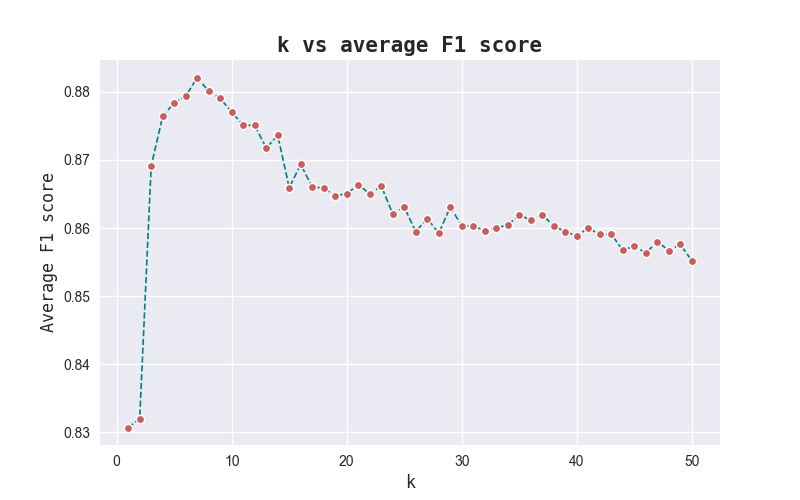

In [29]:
#Creating a figure object with single axes
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (8,5) )

#Seaborn lineplot of k vs avg_f1
sns.lineplot(x = k_values, y = avg_f1_k, ax = ax, marker = 'o', markeredgecolor = 'w', markerfacecolor = 'indianred', 
            markersize = 6, markeredgewidth = 1.1, linewidth = 1.2, c = 'teal', linestyle = '--')

#Labelling the plot 
ax.set_title( "k vs average F1 score", family = "monospace", fontweight="bold", size = 15)
ax.set_ylabel("Average F1 score", family = "monospace", size = 12)
ax.set_xlabel("k", family = "monospace", size = 12)

We shall choose the k value that maximises the average F1 score. This is k = 7.

In [30]:
#Optimal value of k 
f"k = {k_values[ avg_f1_k.index( max(avg_f1_k) ) ]}, F1 score = {avg_f1_k[ avg_f1_k.index( max(avg_f1_k) ) ]}"

'k = 7, F1 score = 0.8821263135752272'

### 2.1) Conclusion: K-Nearest Neighbours
The best k-nn model, with k = 7, correctly classifies properties into House or Apartment around 88% of the time. Now, let's deploy the model.

## 3) Model Deployment

Equipped with the optimal k-nn model with k = 7 and trained on the Greenwich properties dataset, we deploy the model and use it for classifying the properties in the neighbouring Borough of Bexley. Let's see how well the model works.

In [31]:
#Importing the bexley csv; obtained using the same web scraping code with slight modification
bexley = pd.read_csv("rightmove_Bexley.csv")
bexley.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Price (£)      1025 non-null   object 
 1   Property Type  1020 non-null   object 
 2   Bedrooms       1010 non-null   float64
 3   Bathrooms      964 non-null    float64
 4   Size, sq. ft.  109 non-null    object 
dtypes: float64(2), object(3)
memory usage: 40.2+ KB


In [32]:
#Changing the price column format and dtype
bexley["Price (£)"] = bexley["Price (£)"].apply(lambda x: ''.join(x.split(','))).astype('float64')

In [33]:
bexley["Property Type"].unique()

array(['Semi-Detached', 'End of Terrace', 'Terraced', 'House', 'Detached',
       'Maisonette', 'Bungalow', 'Flat', 'Penthouse', 'Apartment',
       'Ground Maisonette', 'Link Detached House', 'Plot', 'Studio',
       'Retirement Property', 'Ground Flat', 'Semi-Detached Bungalow',
       'Detached Bungalow', 'Town House', 'Land', nan, 'Cottage',
       'Character Property'], dtype=object)

In [34]:
#Changing the apartment like categories to "Apartment"
apartment_type = ["Flat", "Apartment", "Maisonette", "Ground Maisonette", "Ground Flat", "Studio", "Penthouse"]
for type in apartment_type:
    bexley["Property Type"].replace(type, "Apartment", inplace = True)
    
#Changing the house like categories to "House"
house_type = ["Semi-Detached", "Terraced", "End of Terrace", "Detached", "Bungalow", "House", "Retirement Property", 
              "Semi-Detached Bungalow", "Detached Bungalow", "Link Detached House", "Town House", "Cottage"]
for type in house_type:
    bexley["Property Type"].replace(type, "House", inplace = True)

#Dropping the unwanted property types
indices = bexley[ (bexley["Property Type"] == "Land") | (bexley["Property Type"] == "Plot") |
       (bexley["Property Type"] == "Character Property") ].index
for index in indices:
    bexley.drop( index = index, inplace = True )

#Dropping missing values
bexley.dropna( subset = ["Price (£)", "Property Type", "Bedrooms", "Bathrooms"], inplace = True)

In [35]:
#Reset the index
bexley.reset_index(drop = True, inplace = True)

In [36]:
bexley.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 951 entries, 0 to 950
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Price (£)      951 non-null    float64
 1   Property Type  951 non-null    object 
 2   Bedrooms       951 non-null    float64
 3   Bathrooms      951 non-null    float64
 4   Size, sq. ft.  107 non-null    object 
dtypes: float64(3), object(2)
memory usage: 37.3+ KB


In [37]:
#Pipeline object for our model to be deployed
pipe = Pipeline( [('Scaling', StandardScaler()), ('Classifier', KNC( n_neighbors = 7 ) )] )

In [38]:
#Fitting the model so it is ready to be deployed
X_train = properties[features]
y_train = properties[ "Property Type" ]

pipe.fit(X_train, y_train)

Pipeline(steps=[('Scaling', StandardScaler()),
                ('Classifier', KNeighborsClassifier(n_neighbors=7))])

In [39]:
#Properties in bexley used as the 'test' dataset
X_test = bexley[features]
y_test = bexley["Property Type"]

In [40]:
#Model prediction
y_pred = pipe.predict(X_test)

In [41]:
#Model evaluation
print( classification_report(y_pred, y_test) )

              precision    recall  f1-score   support

   Apartment       0.97      0.63      0.76       460
       House       0.74      0.98      0.84       491

    accuracy                           0.81       951
   macro avg       0.86      0.80      0.80       951
weighted avg       0.85      0.81      0.80       951



In [42]:
#Average f1 score
h = f1_score(y_pred, y_test, pos_label = "House")
a = f1_score(y_pred, y_test, pos_label = "Apartment")

2/(1/a + 1/h)

0.8003728444927761

## 3.1) Conclusion

We find that the k-nearest neighbours model developed using the dataset for Greenwich is able to correctly classify around 80% of the properties in Bexley. Thus, our deployed model has an effectiveness of ~80%. 

## Author 
Abhay Shrestha